In this notebook, we take our first shot at comparing an ELO model to the odds model, and looking at the biggest mistakes the ELO model makes!

In [1]:
from tennis_new.model.config.elo.hardcourt import HardCourtELO

hard = HardCourtELO()

In [2]:
from tennis_new.fetch.get_joined import read_joined

jd = read_joined() 
assert jd['tourney_surface'].notnull().all()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
to_fit = jd[jd['score'].notnull()]  # Don't fit on weird matches with scores missing
to_fit = to_fit[to_fit['score'].map(lambda x: 'RET' not in x)]  # Don't fit on matches where one player retired
to_fit = to_fit[to_fit['score'].map(lambda x: 'W/O' not in x)]  # Don't fit on walkovers

In [4]:
with_score = jd[jd['score'].notnull()]
with_score[with_score['score'].map(lambda x: 'W/O' in x)][[
    'winner_name',
    'loser_name',
    'score',
    'tourney_title',
    'tourney_url_suffix'
]].tail(20)

,winner_name,loser_name,score,tourney_title,tourney_url_suffix
368344,Taylor Fritz,Richard Gasquet,(W/O),Open Parc Auvergne-Rhone-Alpes Lyon,/en/scores/archive/lyon/7694/2019/results
368882,Attila Balazs,Johannes Haerteis,(W/O),Moneta Czech Open,/en/scores/archive/prostejov/558/2019/results
369091,Maxime Janvier,Mathias Bourgue,(W/O),Open Sopra Steria de Lyon,/en/scores/archive/lyon/7536/2019/results
369200,Felix Auger-Aliassime,Milos Raonic,(W/O),MercedesCup,/en/scores/archive/stuttgart/321/2019/results
369400,Marcelo Tomas Barrios Vera,Shuichi Sekiguchi,(W/O),Fergana Challenger,/en/scores/archive/fergana/603/2019/results
369445,Feliciano Lopez,Juan Martin del Potro,(W/O),Fever-Tree Championships,/en/scores/archive/london/311/2019/results
370024,Javier Barranco Cosano,Maximilian Marterer,(W/O),Sparkassen Open,/en/scores/archive/braunschweig/526/2019/results
370164,Guillermo Garcia-Lopez,Aldin Setkic,(W/O),Internazionali di Tennis,/en/scores/archive/perugia/9001/2019/results
370208,Jason Kubler,Thanasi Kokkinakis,(W/O),Winnetka,/en/scores/archive/winnetka/228/2019/results
371240,Feliciano Lopez,Ivo Karlovic,(W/O),Coupe Rogers,/en/scores/archive/montreal/421/2019/results


In [5]:
to_fit['tourney_surface'].value_counts()

Clay      150703
Hard      144121
Grass      38194
Carpet     28361
Name: tourney_surface, dtype: int64

In [6]:
hard.fit(to_fit)

In [7]:
to_fit.shape

(361379, 28)

In [8]:
import pandas as pd

history_df = pd.DataFrame(hard.predictor.history)
history_df.head()

,elo1,elo2,elo_match_prediction,match_id,p1_id,p2_id
0,1500.000000,1500.000000,0.500000,Spencer Gore*F. Langham*1877_540*Quarter-Finals,Spencer Gore,F. Langham
1,1500.000000,1500.000000,0.500000,C. Heathcote*J. Marshall*1877_540*Quarter-Finals,C. Heathcote,J. Marshall
2,1500.000000,1500.000000,0.500000,William Marshall*L. Erskine*1877_540*Quarter-F...,William Marshall,L. Erskine
3,1545.484895,1545.484895,0.500000,Spencer Gore*C. Heathcote*1877_540*Semi-Finals,Spencer Gore,C. Heathcote
4,1587.770710,1545.484895,0.560555,Spencer Gore*William Marshall*1877_540*Finals,Spencer Gore,William Marshall


In [9]:
jd = pd.merge(
    jd,
    history_df[['match_id', 'elo1', 'elo2', 'elo_match_prediction']],
    on='match_id',
    how='left'
)

In [10]:
# assert jd[jd['elo_match_prediction'].isnull()]['score'].isnull().all()

In [11]:
jd[[
    'winner_name',
    'loser_name',
    'tourney_dates',
    'tourney_title',
    'elo1',
    'elo2',
    'elo_match_prediction'
]].head(20)

,winner_name,loser_name,tourney_dates,tourney_title,elo1,elo2,elo_match_prediction
0,Spencer Gore,F. Langham,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
1,C. Heathcote,J. Marshall,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
2,William Marshall,L. Erskine,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
3,Spencer Gore,C. Heathcote,1877.07.09,Wimbledon,1545.484895,1545.484895,0.500000
4,Spencer Gore,William Marshall,1877.07.09,Wimbledon,1587.770710,1545.484895,0.560555
5,L. Erskine,Herbert Lawford,1878.07.08,Wimbledon,1454.515105,1500.000000,0.434913
6,Frank Hadow,L. Erskine,1878.07.08,Wimbledon,1500.000000,1502.305400,0.496682
7,Frank Hadow,Spencer Gore,1878.07.08,Wimbledon,1545.786705,1622.712893,0.391069
8,John Hartley,C. Parr,1879.07.07,Wimbledon,1500.000000,1500.000000,0.500000
9,John Hartley,Vere St. Leger Goold,1879.07.07,Wimbledon,1545.484895,1500.000000,0.565087


#### Read Odds Data

In [12]:
odds = pd.read_csv("../../merged_2018.csv")
odds.head()

,loser_id,loser_name,loser_url,match_stats_url,round,round_order,score,winner_id,winner_name,winner_url,...,EXL,LBW,LBL,PSW,PSL,MaxW,MaxL,AvgW,AvgL,odds_match_id
0,ma30,GILLES MULLER,/en/players/gilles-muller/ma30/overview,/en/scores/2018/339/MS019/match-stats?isLive=F...,Round of 32,4,63;76,ch27,HYEON CHUNG,/en/players/hyeon-chung/ch27/overview,...,2.30,1.53,2.50,1.70,2.26,1.70,2.55,1.59,2.35,8
1,sm37,DIEGO SCHWARTZMAN,/en/players/diego-schwartzman/sm37/overview,/en/scores/2018/339/MS023/match-stats?isLive=F...,Round of 32,4,64;76,d801,ALEXANDR DOLGOPOLOV,/en/players/alexandr-dolgopolov/d801/overview,...,1.65,2.20,1.67,2.24,1.71,2.29,1.77,2.17,1.68,0
2,d923,DAMIR DZUMHUR,/en/players/damir-dzumhur/d923/overview,/en/scores/2018/339/MS028/match-stats?isLive=F...,Round of 32,4,67;63;62,i165,DENIS ISTOMIN,/en/players/denis-istomin/i165/overview,...,1.47,2.50,1.53,2.80,1.49,2.80,1.57,2.53,1.51,10
3,sj55,JOHN-PATRICK SMITH,/en/players/john-patrick-smith/sj55/overview,/en/scores/2018/339/MS024/match-stats?isLive=F...,Round of 32,4,64;75,z168,MISCHA ZVEREV,/en/players/mischa-zverev/z168/overview,...,2.50,1.57,2.37,1.44,3.00,1.57,3.00,1.44,2.73,4
4,j386,STEVE JOHNSON,/en/players/steve-johnson/j386/overview,/en/scores/2018/339/MS026/match-stats?isLive=F...,Round of 32,4,76;64,dh58,ALEX DE MINAUR,/en/players/alex-de-minaur/dh58/overview,...,1.38,2.75,1.44,3.14,1.41,3.25,1.44,2.96,1.39,1


In [13]:
# Remove rows with no odds
odds = odds[odds['B365L'].notnull() & odds['B365W'].notnull()].copy()

In [14]:
odds['winner_threshold_prob'] = 1. / odds['B365W']
odds['loser_threshold_prob'] = 1. / odds['B365L']
odds['total_threshold_prob'] = odds['winner_threshold_prob'] + odds['loser_threshold_prob']

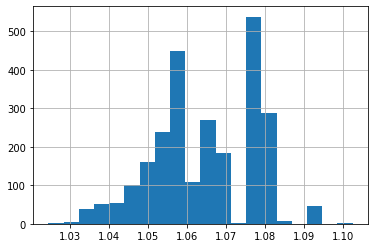

In [15]:
# Ensure that the total prob is always > 1
%matplotlib inline

assert odds['total_threshold_prob'].min() > 1
odds['total_threshold_prob'].hist(bins=20)

In [16]:
odds['implied_prob'] = odds['winner_threshold_prob'] / odds['total_threshold_prob']

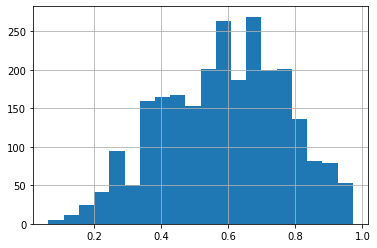

In [17]:
assert (odds['implied_prob'] < odds['winner_threshold_prob']).all()
odds['implied_prob'].hist(bins=20)

In [18]:
# How many matches in 2018 in total?
(jd['year'] == 2018).sum()

12784

In [19]:
# How many ATP matches?
jd_2018 = jd[jd['year'] == 2018]
jd_2018['tour_type'].value_counts()

challenger    8826
atp           3958
Name: tour_type, dtype: int64

In [20]:
odds_cols = [x for x in odds if x not in jd] + ['match_id']
sorted(odds_cols)

['ATP',
 'AvgL',
 'AvgW',
 'B365L',
 'B365W',
 'Best of',
 'Comment',
 'Court',
 'Date',
 'EXL',
 'EXW',
 'L1',
 'L2',
 'L3',
 'L4',
 'L5',
 'LBL',
 'LBW',
 'LPts',
 'LRank',
 'Location',
 'Loser',
 'Lsets',
 'MaxL',
 'MaxW',
 'PSL',
 'PSW',
 'Round',
 'Series',
 'Surface',
 'Tournament',
 'W1',
 'W2',
 'W3',
 'W4',
 'W5',
 'WPts',
 'WRank',
 'Winner',
 'Wsets',
 'implied_prob',
 'loser_last_name',
 'loser_threshold_prob',
 'match_id',
 'odds_match_id',
 'total_threshold_prob',
 'winner_last_name',
 'winner_threshold_prob']

In [21]:
jd_odds = pd.merge(
    jd,
    odds[odds_cols],
    on='match_id',
    how='left'
)

In [22]:
# How many matches missing odds?
jd_odds['odds_match_id'].notnull().value_counts()

False    370693
True       2543
Name: odds_match_id, dtype: int64

In [23]:
missing = jd_odds[
    (jd_odds['tour_type'] == 'atp') &
    (jd_odds['year'] == 2018) &
    (jd_odds['odds_match_id'].isnull())
]

In [24]:
pd.set_option('display.max_rows', 100000)

top_tourneys = missing[missing['tourney_title'].isin(missing['tourney_title'].value_counts().head(20).index)]
top_tourneys.groupby('tourney_title').apply(
    lambda x: x['round'].value_counts()
)

tourney_title                                      
ATP Masters 1000 Canada        1st Round Qualifying    14
                               2nd Round Qualifying     7
                               Round of 64              1
ATP Masters 1000 Cincinnati    1st Round Qualifying    14
                               2nd Round Qualifying     7
                               Semi-Finals              1
ATP Masters 1000 Indian Wells  1st Round Qualifying    24
                               2nd Round Qualifying    12
                               Round of 32              2
                               Round of 16              1
                               Round of 64              1
                               Round of 128             1
ATP Masters 1000 Madrid        1st Round Qualifying    14
                               2nd Round Qualifying     7
ATP Masters 1000 Miami         1st Round Qualifying    24
                               2nd Round Qualifying    12
ATP Masters 1000 Mon

It looks like most cases with the odds missing are very early rounds in the tournament.  Our hunch is that the rest of them are retiree matches...

In [25]:
# Check that other cases are all retires 
# TODO: More rigorous check
missing[missing['round'] == 'Round of 128']['score'].head(100)

351592             62;41 (RET)
353283             63;21 (RET)
356308                61;64;76
356347             36;34 (RET)
356357             61;20 (RET)
357704          64;75;20 (RET)
360119             63;34 (RET)
360125          75;61;11 (RET)
360141       46;76;60;20 (RET)
360146          75;57;41 (RET)
360150    76;67;46;61;41 (RET)
360151       64;64;26;31 (RET)
360156       64;64;46;21 (RET)
360161       62;26;76;30 (RET)
360178       67;64;62;21 (RET)
Name: score, dtype: object

There are a few other missing cases -- we'll deal with these later...

In [26]:
SURFACE = 'Hard'

has_odds = jd_odds[
    jd_odds['odds_match_id'].notnull() &
    (jd_odds['tourney_surface'] == SURFACE)
].copy()

In [27]:
# How many matches are missing?
has_odds['tourney_title'].value_counts().head()

Australian Open                  123
US Open                          114
ATP Masters 1000 Miami            95
ATP Masters 1000 Indian Wells     90
ATP Masters 1000 Cincinnati       54
Name: tourney_title, dtype: int64

In [28]:
# How good is each casino?
CASINOS = [
    'B365',
    'Avg',
    'EX',
    'LB',
    'Max',
    'PS',
]
rel = jd_odds[
    jd_odds[
        ['%sL' % casino for casino in CASINOS] + 
        ['%sW' % casino for casino in CASINOS]
    ].notnull().all(axis=1) &
    (jd_odds['tourney_surface'] == 'Hard')
]
for casino in CASINOS:
    acc = ((rel['%sL' % casino] >= rel['%sW' % casino]).mean())
    print(casino, acc)

B365 0.6930193439865433
Avg 0.6820857863751051
EX 0.6921783010933558
LB 0.695542472666106
Max 0.6812447434819175
PS 0.6837678721614803


PS is the worst bookie.  B365 is pretty good - we'll continue to measure against them!

In [29]:
# B365 Accuracy on matches where B365 is not null
{
    'B365 Cheating Accuracy': (has_odds['B365L'] >= has_odds['B365W']).mean(),
    'B365 Pessimistic Accuracy': (has_odds['B365L'] > has_odds['B365W']).mean(),
    'ELO Accuracy': (has_odds['elo_match_prediction'] > 0.5).mean(),
    'Rank Accuracy': (has_odds['LRank'] > has_odds['WRank']).mean()
}

{'B365 Cheating Accuracy': 0.700836820083682,
 'B365 Pessimistic Accuracy': 0.6806136680613668,
 'ELO Accuracy': 0.6687587168758717,
 'Rank Accuracy': 0.6499302649930265}

In [30]:
not_even = has_odds[
    (has_odds['B365L'] != has_odds['B365W'])
]
{
    'B365 Accuracy': (not_even['B365L'] > not_even['B365W']).mean(),
    'ELO Accuracy': (not_even['elo_match_prediction'] > 0.5).mean(),
    'Rank Accuracy': (not_even['LRank'] > not_even['WRank']).mean()
}

{'B365 Accuracy': 0.6946619217081851,
 'ELO Accuracy': 0.6718861209964413,
 'Rank Accuracy': 0.6512455516014235}

We do see an improvement from not training on matches with retirements, but not from removing walkovers.  We do decidedely outdo the ATP rankings, thankfully...

In [31]:
# How many even odds matches are there?
even = has_odds[has_odds['B365L'] == has_odds['B365W']]
even.shape[0]

29

In [32]:
# How often do we get things right with even odds?
(even['elo_match_prediction'] > 0.5).value_counts()

True     15
False    14
Name: elo_match_prediction, dtype: int64

In [33]:
# Z-test for above cases...is it a fluke?
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(
    (even['elo_match_prediction'] > 0.5).sum(),
    even.shape[0],
    0.5,
    'larger'
)

(0.185805838239302, 0.4262985130046936)

Could be, but we'd have to be relatively lucky...

In [34]:
# Accuracy of ATP Rankings
(has_odds['WRank'] < has_odds['LRank']).mean()

0.6499302649930265

Quite a bit worse than the odds for the matched cases!  These do rule out walkovers and retirements and such though...But we can make our model better!  And these are the closing odds, so they're probably not as good at the opening!  We are better than the ATP rankings though...

In [35]:
errors = has_odds[
    (has_odds['elo_match_prediction'] < 0.5) &  # We're wrong
    (has_odds['implied_prob'] > 0.5)  # Odds thought eventual outcome was very likely
].copy()

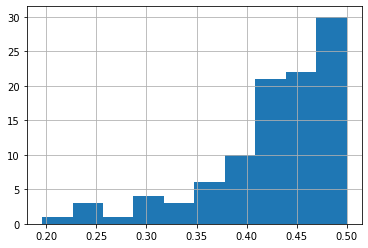

In [36]:
%matplotlib inline

errors['elo_match_prediction'].hist(bins=10)

At least when we're wrong, we're usually pretty close to right

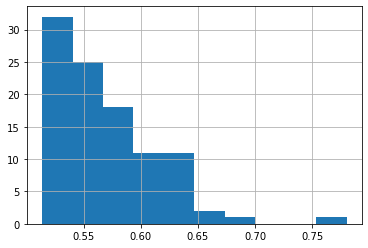

In [37]:
errors['implied_prob'].hist(bins=10)

In [38]:
errors[[
    'B365W',
    'B365L',
    'elo_match_prediction',
    'winner_name',
    'loser_name'
]].head()

,B365W,B365L,elo_match_prediction,winner_name,loser_name
351007,1.53,2.37,0.454470,Hyeon Chung,Gilles Muller
351017,1.66,2.10,0.384041,Michael Mmoh,Federico Delbonis
351029,1.72,2.10,0.319733,Alex de Minaur,Michael Mmoh
351120,1.72,2.00,0.458860,Borna Coric,Pablo Carreno Busta
351143,1.36,3.00,0.425855,Nicolas Jarry,Pablo Andujar


In [39]:
errors.sort_values('implied_prob', ascending=False, inplace=True)
errors[[
    'B365W',
    'B365L',
    'elo_match_prediction',
    'elo1',
    'elo2',
    'winner_name',
    'loser_name',
    'implied_prob',
    'Date'
]].head()

,B365W,B365L,elo_match_prediction,elo1,elo2,winner_name,loser_name,implied_prob,Date
360177,1.22,4.33,0.366741,1900.213600,1995.102722,Tennys Sandgren,Viktor Troicki,0.780180,8/28/18
351143,1.36,3.00,0.425855,1794.324716,1846.228495,Nicolas Jarry,Pablo Andujar,0.688073,1/1/18
362260,1.40,2.75,0.248870,1775.705461,1967.602630,Salvatore Caruso,Yuki Bhambri,0.662651,10/17/18
352458,1.40,2.75,0.493046,2117.138462,2121.971241,Andrey Rublev,Damir Dzumhur,0.662651,2/15/18
363065,1.50,2.62,0.496523,2175.162596,2177.578747,Karen Khachanov,John Isner,0.635922,11/1/18


In [40]:
from matplotlib import pyplot as plt

PRINT_COLS = ['tourney_dates', 'winner_name', 'loser_name', 'elo1', 'elo2', 'elo']


def _get_player_df(pid):
    rel = jd[
        (jd['winner_id'] == pid) |
        (jd['loser_id'] == pid)
    ].copy()
    rel['elo'] = rel['elo1']
    rel.loc[jd['loser_id'] == pid, 'elo'] = rel.loc[
        jd['loser_id'] == pid, 'elo2'
    ]
    rel['tourney_dates'] = pd.to_datetime(rel['tourney_dates'])
    rel['elo_diff'] = rel['elo'].diff().shift(-1)
    rel['elo_abs_diff'] = rel['elo_diff'].abs()
    return rel



def investigate_match(match_row):
    print(match_row[[
        'winner_name',
        'loser_name',
        'tourney_title',
        'score',
        'elo1',
        'elo2',
        'elo_match_prediction',
        'implied_prob',
        'Date'
    ]].to_string())
    wid = match_row['winner_id']
    lid = match_row['loser_id']
    wdf = _get_player_df(wid)
    ldf = _get_player_df(lid)
    rel_wdf = wdf[wdf['tourney_dates'] > pd.to_datetime('2015.01.01')]  # TODO: Unhardcode
    rel_ldf = ldf[ldf['tourney_dates'] > pd.to_datetime('2015.01.01')]  # TODO: Unhardcode

    tourneys = rel_wdf.groupby('tourney_year_id').apply(
        lambda x: pd.Series({
            'tourney_name': x['tourney_title'].iloc[0],
            'total_elo_diff': x['elo_diff'].sum(),
            'tourney_dates': x['tourney_dates'].iloc[0],
            'tourney_surface': x['tourney_surface'].iloc[0]
        })
    )
    print("WINNER BEST TOURNEYS: \n")
    print(tourneys.sort_values('total_elo_diff', ascending=False).head(5))
    
    
    
    print("WINNER: \n")
    print(wdf[wdf['tourney_dates'] <= match_row['tourney_dates']][PRINT_COLS].tail(50).to_string())
    print("WINNER BIG DIFFS: \n")
    big_diffs = rel_wdf.sort_values('elo_abs_diff', ascending=False).head(5)  # TODO: Unhardcode
    print(big_diffs[PRINT_COLS].to_string())
    
    print("LOSER: \n")
    print(ldf[ldf['tourney_dates'] <= match_row['tourney_dates']][PRINT_COLS].tail(50).to_string())
    print("LOSER BIG DIFFS: \n")
    big_diffs = rel_ldf.sort_values('elo_abs_diff', ascending=False).head(5)  # TODO: Unhardcode
    print(big_diffs[PRINT_COLS].to_string())

    plt.plot(
        pd.to_datetime(rel_wdf['tourney_dates']), rel_wdf['elo']
    )
    
    plt.plot(
        pd.to_datetime(rel_ldf['tourney_dates']), rel_ldf['elo']
    )
    plt.vlines(
        pd.to_datetime(match_row['Date']),
        min(rel_wdf['elo'].min(), rel_ldf['elo'].min()),
        max(rel_wdf['elo'].max(), rel_ldf['elo'].max()),
        linestyles='dashed',
        colors='red'
    )

winner_name             Nicolas Jarry
loser_name              Pablo Andujar
tourney_title                    Pune
score                        67;64;75
elo1                          1794.32
elo2                          1846.23
elo_match_prediction         0.425855
implied_prob                 0.688073
Date                           1/1/18
WINNER BEST TOURNEYS: 

                  tourney_name  total_elo_diff tourney_dates tourney_surface
tourney_year_id                                                             
2017_6963              Morelos       58.479942    2017-02-20            Hard
2016_7235        Drummondville       51.270947    2016-03-14            Hard
2017_1539                 Leon       43.617716    2017-03-28            Hard
2016_5067             Savannah       36.610734    2016-04-18            Clay
2015_7161                Quito       36.510703    2015-02-02            Clay
WINNER: 

       tourney_dates               winner_name              loser_name         elo1  

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


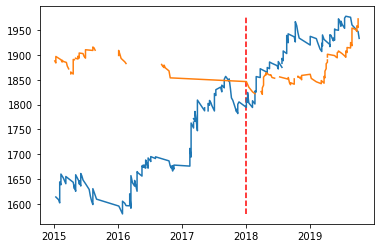

In [41]:
investigate_match(errors.iloc[1])

Many of our errors are when a player hasn't played in a long time...

#### Calibration Analysis

Let's see how well calibrated our model is!

In [42]:
# TODO: Rename variables here for readability
w = jd[
    (jd['tourney_dates'] > '2015.01.01') &
    (jd['tourney_surface'] == "Hard") &
    (jd['elo_match_prediction'].notnull())
].copy()

For calibration, we'll include every point with both definitions of 0 / 1, rather than randomizing which player is "home" and "away".  This reduces noise.

In [43]:
w['y'] = 1
# w['pred'] = w['implied_prob']
w['pred'] = w['elo_match_prediction']
reverse = w.copy()
reverse['pred'] = 1. - w['elo_match_prediction']
reverse['y'] = 0
calibrate_df = pd.concat([
    w, reverse
])

In [44]:
calibrate_df.shape

(59452, 33)

Text(0, 0.5, 'predicted prob')

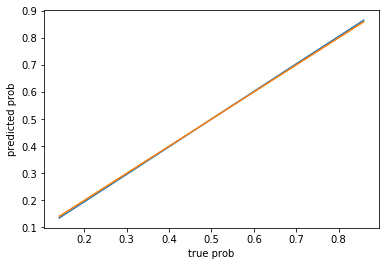

In [45]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

_x, _y = calibration_curve(calibrate_df['y'], calibrate_df['pred'], 20)
plt.plot(_x, _y)
plt.plot(_x, _x)
plt.xlabel('true prob')
plt.ylabel('predicted prob')

Pretty well calibrated already!

In [46]:
from sklearn.isotonic import IsotonicRegression 

iso = IsotonicRegression()
iso.fit(calibrate_df['pred'], calibrate_df['y'])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

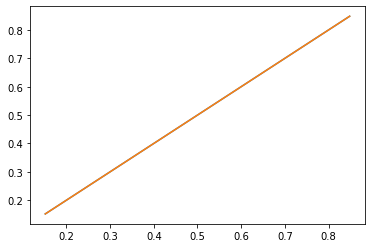

In [47]:
calibrated = iso.predict(calibrate_df['pred'].values)
verify_x, verify_y = calibration_curve(calibrate_df['y'].values, calibrated, 20)
plt.plot(verify_x, verify_y)
plt.plot(verify_x, verify_x)

Good, calibrated!

#### How does model with perfect calibration do!?

In [48]:
has_odds['calibrated_pred'] = iso.predict(has_odds['elo_match_prediction'])

In [49]:
BUFFER_LOW = 0.01
BUFFER_HIGH = 0.05
PRED_COL = 'elo_match_prediction'  # TODO: Calibrate? 
# PRED_COL = 'calibrated_pred'  # NOTE: Cheating! 

def _get_bet(row, buffer_low=BUFFER_LOW, buffer_high=BUFFER_HIGH):
    if (row['winner_threshold_prob'] + buffer_high) > row[PRED_COL] > (row['winner_threshold_prob'] + buffer_low):
        return row['B365W'] - 1.
    elif (row['loser_threshold_prob'] + buffer_high) > (1. - row[PRED_COL]) >  (row['loser_threshold_prob'] + buffer_low):
        return -1. 
    else:
        return None

has_odds['return'] = has_odds.apply(_get_bet, axis=1)
has_odds['total_return'] = has_odds['return'].cumsum()

In [50]:
has_odds[[
    'Date', 'winner_name', 'loser_name', PRED_COL, 'implied_prob', 'B365W', 'B365L', 'return', 'total_return'
]]

,Date,winner_name,loser_name,elo_match_prediction,implied_prob,B365W,B365L,return,total_return
351007,1/2/18,Hyeon Chung,Gilles Muller,0.454470,0.607692,1.530,2.37,NaN,NaN
351008,12/31/17,Alexandr Dolgopolov,Diego Schwartzman,0.457317,0.422572,2.200,1.61,NaN,NaN
351009,1/2/18,Denis Istomin,Damir Dzumhur,0.276409,0.354680,2.620,1.44,-1.00,-1.00
351010,1/1/18,Mischa Zverev,John-Patrick Smith,0.766313,0.662651,1.400,2.75,NaN,NaN
351011,12/31/17,Alex de Minaur,Steve Johnson,0.141738,0.337349,2.750,1.40,NaN,NaN
351012,1/1/18,Jared Donaldson,Jordan Thompson,0.492164,0.500000,1.830,1.83,NaN,NaN
351013,1/1/18,Matthew Ebden,Frances Tiafoe,0.425079,0.375000,2.500,1.50,1.50,0.50
351014,1/2/18,Kyle Edmund,Denis Shapovalov,0.624393,0.537634,1.720,2.00,0.72,1.22
351015,1/1/18,Ryan Harrison,Leonardo Mayer,0.601953,0.577428,1.610,2.20,NaN,NaN
351016,1/2/18,John Millman,Peter Polansky,0.671707,0.709607,1.330,3.25,-1.00,0.22


In [51]:
wubba = has_odds.copy()
wubba['spread_bin'] = pd.qcut(has_odds['total_threshold_prob'], 5)

In [52]:
# Do we do better when the spread is smaller?
wubba.groupby('spread_bin').apply(
    lambda x: (x.shape[0], x['return'].notnull().sum(), x['return'].sum() / x['return'].notnull().sum())
)

spread_bin
(1.0230000000000001, 1.055]     (292, 95, -0.36147368421052634)
(1.055, 1.06]                  (301, 82, -0.025731707317073176)
(1.06, 1.069]                    (274, 77, 0.07922077922077927)
(1.069, 1.078]                  (298, 80, -0.26974999999999993)
(1.078, 1.103]                   (269, 70, 0.03428571428571431)
dtype: object

Doesn't really look like we do better when the spread is smaller...

In [53]:
with_bets = has_odds[
    has_odds['return'].notnull()
].copy()
with_bets['date'] = pd.to_datetime(with_bets['Date'])
with_bets.sort_values('date', inplace=True)
(with_bets['return'] > 0).mean()

0.4752475247524752

In [54]:
# How often do we bet on the favorites?
(with_bets['B365W'] < with_bets['B365L']).mean()

0.6881188118811881

In [ ]:
plt.plot(
    pd.to_datetime(with_bets['Date']),
    with_bets['total_return']
)
plt.xticks(rotation=45)

Flat region is clay / grass season

In [ ]:
avg_pred = (has_odds['implied_prob'] + has_odds['elo_match_prediction']) / 2.